# Biodiversity Intactness Analysis for Phoenix Subdivision

## Author: Takeen Shamloo
View full repo: [GitHub Link](https://github.com/takeenshamloo/biodiversity-intactness-phoenix)

## About
### Purpose
This notebook analyzes the Biodiversity Intactness Index (BII) within the Phoenix subdivision for the years 2017 and 2020. It calculates biodiversity loss, visualizes the results, and identifies areas where biodiversity was maintained or declined.

### Highlights
1. Data exploration and masking of biodiversity data.
2. Visualization of BII values for 2017 and 2020.
3. Overlay of biodiversity loss with transparent backgrounds.
4. Calculation of the percentage of area with biodiversity changes.

### About the Data
This analysis utilizes two datasets to explore biodiversity changes within the Phoenix subdivision for the years 2017 and 2020:

1. **Biodiversity Intactness Index (BII) Time Series**  
   - **Source:** Microsoft Planetary Computer STAC catalog, io-biodiversity collection.  
   - **Description:** This dataset provides rasterized BII values for 2017 and 2020. These values indicate the percentage of original biodiversity remaining after human activity. Higher values represent healthier biodiversity conditions.  
   - **Focus:** The BII dataset covers a broader region beyond Phoenix. However, this analysis specifically focuses on the Phoenix subdivision by applying spatial masking.  
   - **Spatial Extent Used for Analysis:**  
     - Longitude: -112.826843 (west) to -111.184387 (east)  
     - Latitude: 32.974108 (south) to 33.863574 (north)  

2. **Phoenix Subdivision Shapefile**  
   - **Source:** U.S. Census Bureau, Census County Subdivision shapefiles for Arizona.  
   - **Description:** This dataset includes detailed geometries for subdivisions within Arizona, including Phoenix. The shapefile was used to isolate the BII data for the Phoenix area.  

### References
- Microsoft Planetary Computer. (n.d.). Biodiversity intactness data. Retrieved from https://planetarycomputer.microsoft.com
- GeoPandas contributors. (n.d.). GeoPandas documentation. Retrieved from https://geopandas.org
- Rasterio contributors. (n.d.). Rasterio documentation. Retrieved from https://rasterio.readthedocs.io
- U.S. Census Bureau. (n.d.). Census County Subdivision shapefiles for Arizona. Retrieved from https://www.census.gov/geographies/mapping-files.html
---


In [291]:
# Import required libraries
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio
from rasterio.mask import mask
from rasterio.plot import plotting_extent
import numpy as np
import contextily as ctx # Base map
import matplotlib.patches as mpatches # For final legend

# For importing BII Data from Microsoft
from pystac_client import Client
import planetary_computer as pc
import requests

### Code below is used to generate BII Data for 2017/2020
- Should only be ran if needed to generate files again.

## 1. Data Loading and Exploration

### 1.1 Phoenix Subdivision Shapefilez
The Phoenix subdivision shapefile defines the spatial extent of the analysis. To ensure accurate overlays with raster data. The boundary is visualized over a basemap for geographic context.


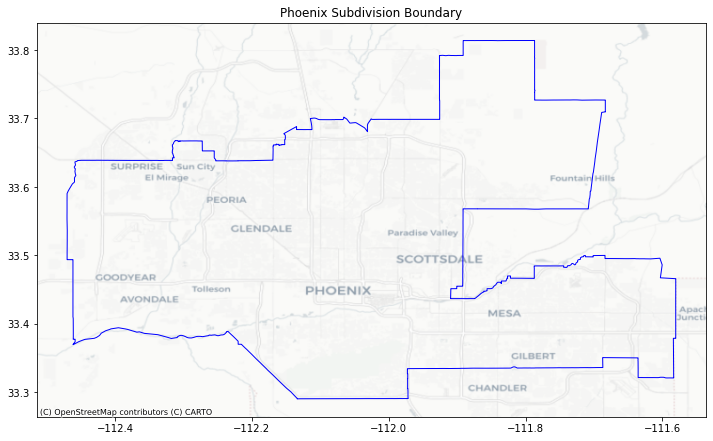

In [292]:
# Load Phoenix subdivision shapefile
shapefile_path = "../data/tl_2020_04_cousub/tl_2020_04_cousub.shp"
county_subdivisions = gpd.read_file(shapefile_path)

# Validate shapefile
assert not county_subdivisions.empty, "Error: Shapefile is empty."

# Filter for Maricopa County and Phoenix subdivision
maricopa_subdivisions = county_subdivisions[county_subdivisions["COUNTYFP"] == "013"]
phoenix_subdivision = maricopa_subdivisions[maricopa_subdivisions["NAME"].str.contains("Phoenix")]

# Validate Phoenix subdivision
assert not phoenix_subdivision.empty, "Error: Phoenix subdivision filter returned no results."

# Plot the Phoenix subdivision for verification
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the boundary of Phoenix subdivision
phoenix_subdivision.boundary.plot(ax = ax, edgecolor = "blue", linewidth = 1, label="Phoenix Subdivision")

# Add the basemap
ctx.add_basemap(ax, crs = phoenix_subdivision.crs.to_string(), source = ctx.providers.CartoDB.Positron)
plt.title("Phoenix Subdivision Boundary")
plt.show()

## 1.2 Biodiversity Intactness Index (BII) Rasters

The Biodiversity Intactness Index (BII) rasters for 2017 and 2020 provide spatial biodiversity metrics. Each pixel value represents the percentage of biodiversity remaining after human activity.

In [293]:
# Load and validate the BII rasters for 2017 and 2020
bii_2017 = rasterio.open("../data/bii_2017.tif")
bii_2020 = rasterio.open("../data/bii_2020.tif")

## 2. Data Masking and Visualization
### 2.1 Masking BII Data

To analyze biodiversity changes specific to the Phoenix subdivision the raster data for 2017 and 2020 are masked to the boundary. This step crops the data within the region of interest.


In [294]:
# Ensure CRS alignment between rasters and Phoenix subdivision
if phoenix_subdivision.crs != bii_2017.crs:
    phoenix_subdivision = phoenix_subdivision.to_crs(bii_2017.crs)
    print("Phoenix subdivision reprojected to match raster CRS.")

# Define a function to mask raster data
def mask_raster(raster, shapefile):
    shapes = [geometry.__geo_interface__ for geometry in shapefile.geometry]
    masked, transform = mask(raster, shapes, crop=True)
    assert masked.size > 0, "Error: Masked raster is empty."
    return masked[0], transform

# Mask the 2017 and 2020 rasters
masked_bii_2017, transform_bii_2017 = mask_raster(bii_2017, phoenix_subdivision)
masked_bii_2020, transform_bii_2020 = mask_raster(bii_2020, phoenix_subdivision)

Phoenix subdivision reprojected to match raster CRS.


### 2.2 Percentage of Area with BII ≥ 0.75 in 2017

Pixels with BII values ≥ 0.75 are considered areas with relatively intact biodiversity. The percentage of such pixels is calculated to quantify biodiversity intactness in the Phoenix subdivision for 2017.

In [295]:
# Calculate percentage of area with BII >= 0.75 in 2017
total_pixels_2017 = masked_bii_2017.size
pixels_bii_2017_high = np.sum(masked_bii_2017 >= 0.75)
percentage_bii_2017_high = (pixels_bii_2017_high / total_pixels_2017) * 100

print(f"Percentage of area with BII >= 0.75 in 2017: {percentage_bii_2017_high:.2f}%")

Percentage of area with BII >= 0.75 in 2017: 4.17%


### 2.3 Percentage of Area with BII ≥ 0.75 in 2020

Using the same method as the previous step we calculate the percentage of such pixels to quantify biodiversity intactness in the Phoenix subdivision for 2020. 

In [296]:
# Calculate percentage of area with BII >= 0.75 in 2020
total_pixels_2020 = masked_bii_2020.size
pixels_bii_2020_high = np.sum(masked_bii_2020 >= 0.75)
percentage_bii_2020_high = (pixels_bii_2020_high / total_pixels_2020) * 100

print(f"Percentage of area with BII >= 0.75 in 2020: {percentage_bii_2020_high:.2f}%")

Percentage of area with BII >= 0.75 in 2020: 3.80%


### 2.4 Visualizing Biodiversity Loss

Here we are visualizing the BII data for the Phoenix subdivision. This visualization gives an overview of intact biodiversity levels using green shading.

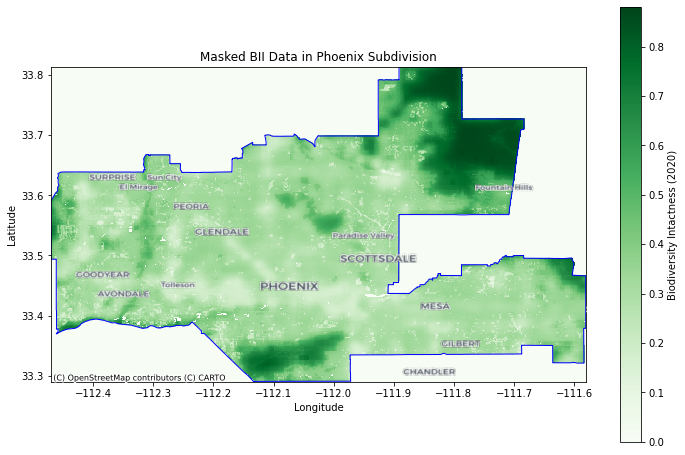

In [297]:
fig, ax = plt.subplots(figsize = (12, 8))

# Display the masked BII 2020 data
masked = ax.imshow(masked_bii_2020, cmap = "Greens", interpolation = "none",
                   extent = plotting_extent(masked_bii_2020, transform_bii_2020))

# Overlay the Phoenix subdivision boundary
phoenix_subdivision.boundary.plot(ax = ax, edgecolor="blue", linewidth = 1, label = "Phoenix Subdivision")

# Add the basemap with reduced alpha
ctx.add_basemap(ax, crs = phoenix_subdivision.crs.to_string(), source = ctx.providers.CartoDB.PositronOnlyLabels)

# Add a colorbar and legend
cbar = plt.colorbar(masked, ax = ax, label = "Biodiversity Intactness (2020)")
plt.title("Masked BII Data in Phoenix Subdivision")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

## 3. Biodiversity Loss Analysis
### 3.1 Calculating Biodiversity Loss

Biodiversity loss is defined as areas where the Biodiversity Intactness Index (BII) dropped below the 0.75 threshold between 2017 and 2020. The percentage of biodiversity loss is calculated relative to the total area of the Phoenix subdivision.

In [298]:
# Identify areas with biodiversity loss (BII >= 0.75 in 2017 but < 0.75 in 2020)
loss_mask = (masked_bii_2017 >= 0.75) & (masked_bii_2020 < 0.75)

# Prepare the loss mask for visualization with transparency
loss_mask_with_nan = np.where(loss_mask, 1, np.nan)  # Set True values to 1, others to NaN

# Calculate loss percentage
total_pixels = masked_bii_2017.size
loss_pixels = np.sum(loss_mask)
loss_percentage = (loss_pixels / total_pixels) * 100
print(f"Percentage of area with biodiversity loss: {loss_percentage:.2f}%")

Percentage of area with biodiversity loss: 0.38%


### 3.2 Visualizing Biodiversity Loss

Regions with biodiversity loss (BII ≥ 0.75 in 2017 but < 0.75 in 2020)

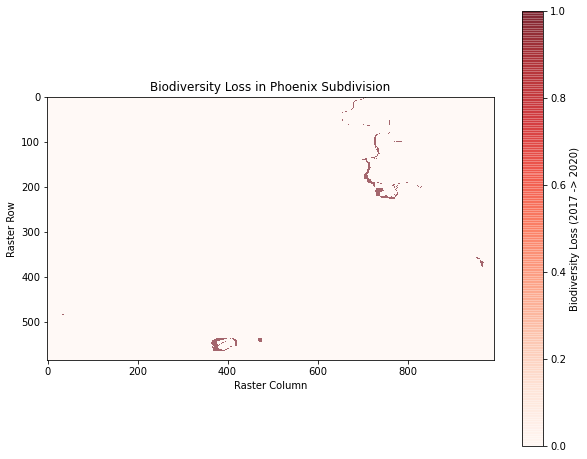

In [299]:
# Plot biodiversity loss
plt.figure(figsize=(10, 8))
plt.imshow(loss_mask, cmap = "Reds", interpolation = "none", alpha=0.6)
plt.colorbar(label = "Biodiversity Loss (2017 -> 2020)")
plt.title("Biodiversity Loss in Phoenix Subdivision")
plt.xlabel("Raster Column")
plt.ylabel("Raster Row")
plt.show()

### 3.3 Overlaying Biodiversity Loss

This visualization highlights areas where biodiversity declined between 2017 and 2020. Regions with biodiversity loss (BII ≥ 0.75 in 2017 but < 0.75 in 2020) are overlaid in red showing our hotspots.

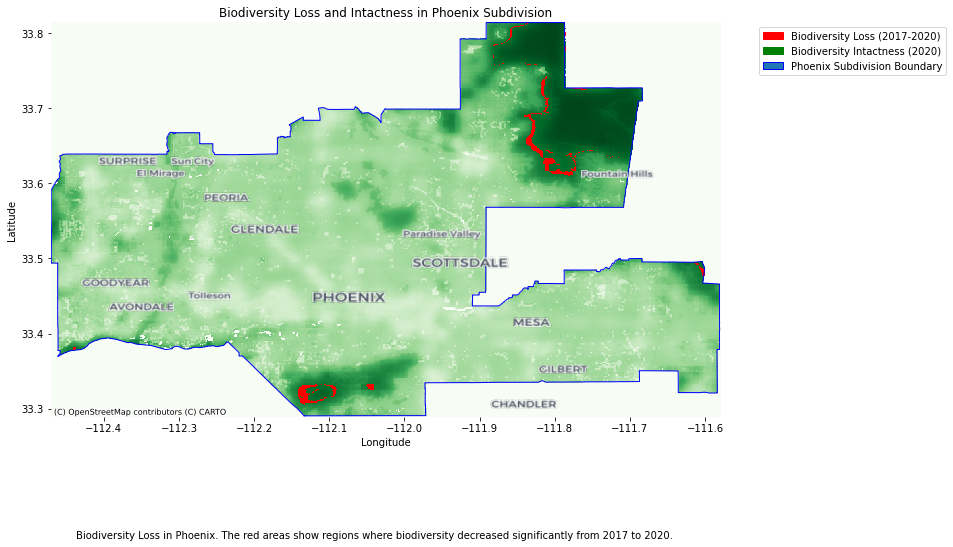

In [300]:
fig, ax = plt.subplots(figsize = (12, 8))
ax.set_frame_on(False) # Remove figure border

# Create an RGBA base array for the masked BII data
extent = plotting_extent(masked_bii_2020, transform_bii_2020)
rgba = plt.cm.Greens(masked_bii_2020 / np.nanmax(masked_bii_2020))  # Normalize masked BII data to 0-1

# Modify RGBA array where the loss mask is True So the red can show through.
loss_mask_indices = np.where(loss_mask_with_nan == 1)
rgba[loss_mask_indices[0], loss_mask_indices[1], :3] = [1, 0, 0]  # RGB = red
rgba[loss_mask_indices[0], loss_mask_indices[1], 3] = 1  # Alpha = 1

# Plot the RGBA image
ax.imshow(rgba, extent = extent, interpolation = "none")

# Overlay the Phoenix subdivision boundary
phoenix_subdivision.boundary.plot(ax = ax, edgecolor = "blue", linewidth = 1, label = "Phoenix Subdivision")

# Add basemap
ctx.add_basemap(ax, crs = phoenix_subdivision.crs.to_string(), source = ctx.providers.CartoDB.PositronOnlyLabels)

# Add custom legend
red_patch = mpatches.Patch(color = 'red', label = 'Biodiversity Loss (2017-2020)')
green_patch = mpatches.Patch(color = 'green', label = 'Biodiversity Intactness (2020)')
blue_patch = mpatches.Patch(edgecolor = 'blue', label = 'Phoenix Subdivision Boundary')
ax.legend(handles = [red_patch, green_patch, blue_patch], bbox_to_anchor = (1.05, 1), loc = "upper left", fontsize = 10)

# Add a figure description directly on the canvas
plt.figtext(0.5, -0.05, "Biodiversity Loss in Phoenix. The red areas show regions where biodiversity decreased significantly from 2017 to 2020.", ha="center", fontsize=10)

# Add title and labels.
plt.title("Biodiversity Loss and Intactness in Phoenix Subdivision")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()